In [1]:
import os 
os.chdir("..")


In [18]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:

mode = "damping"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

dtt = 1e-6
total_time = 4.
total_time, dt = get_total_time_dt(params, dt=dtt, total_time=total_time)
times = np.arange(0, total_time+ dt, dt)



Ntraj = 2000
boundsB= np.arange(.5,4.5,.1)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

er=[]
deter = {}
deter["h0/h1"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]



n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode=mode, dtt=dtt, total_time=total_time)

        for indb,b in enumerate(boundsB):
            stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
            stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b
                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))

100%|██████████| 1999/1999 [27:58<00:00,  1.19it/s]


In [2]:
stops1 = []
for k in stop["_1"].values():
    if len(k) != 0:
        stops1.append(k)
stops1 = np.squeeze(stops1)

NameError: name 'stop' is not defined

In [3]:
stops = []
for k in stop["_1"].values():
    if len(k) != 0:
        stops.append(k)
stops = np.squeeze(stops)


cons = []
anals = []
timbin = []
timanals = []
for indb, b in enumerate(boundsB):
    counts, bins = np.histogram(stops[:,indb], int(len(stops[:,indb])/10), normed=True)
    timms = np.linspace(0,np.max(bins), 100)
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms]
    timbins = .5*(bins[1:] + bins[:-1])
    cons.append(counts)
    anals.append(gp1)
    timbin.append(timbins)
    timanals.append(timms)

NameError: name 'stop' is not defined

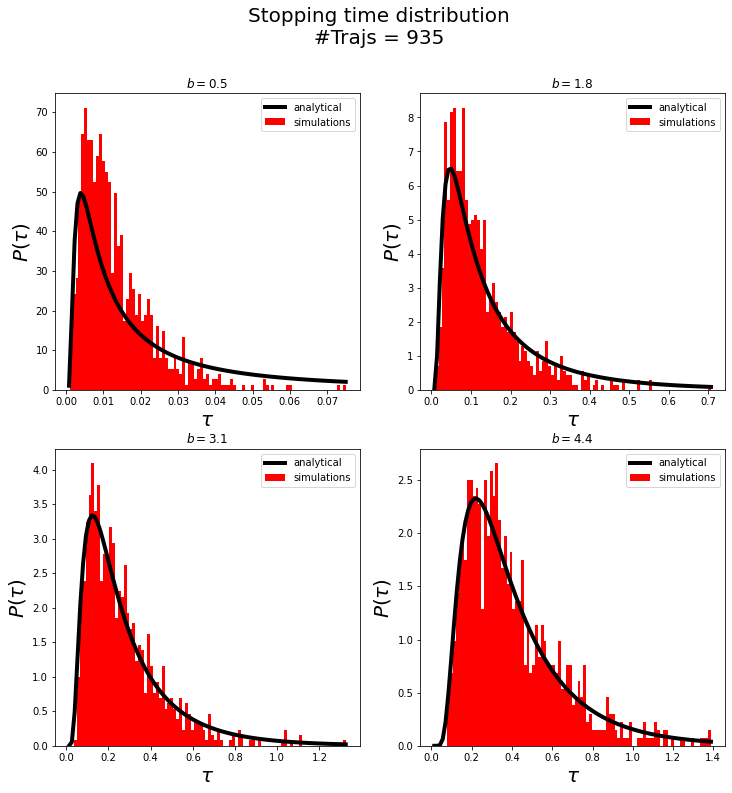

In [93]:
plt.figure(figsize=(12,12))
plt.suptitle("Stopping time distribution\n#Trajs = {}".format(len(stops)),size=20)
axx = [221, 222, 223, 224]
indix = [int(k) for k in np.linspace(0,len(boundsB)-1, 4)]
selected_b = [boundsB[int(k)] for k in indix]
c=-1
for indb, b in zip(indix,selected_b):
    c+=1
    ax = plt.subplot(axx[c])
    ax.set_title('$b=$'+str(np.round(b,2)))
    ax.plot(timanals[indb], anals[indb], linewidth=4, color="black", label="analytical")
    ax.bar(timbin[indb], cons[indb], width=timbin[indb][1]-timbin[indb][0], color="red", label="simulations")
    ax.set_xlabel(r'$\tau$',size=20)
    ax.set_ylabel(r'$P(\tau)$', size=20)
    ax.legend(prop={"size":10})


In [99]:
path = get_def_path()+"results_stopping_time/damping/{}_stats/".format(stops.shape)
path_data = get_def_path()+"results_stopping_time/damping/{}_stats/data/".format(stops.shape)
os.makedirs(path,exist_ok=True)
os.makedirs(path_data,exist_ok=True)


with open(path_data+"stop.pickle","wb") as f:
    pickle.dump(stop, f, protocol=pickle.HIGHEST_PROTOCOL)
np.save(path_data+"timbin", timbin)
np.save(path_data+"timanals", timanals)
np.save(path_data+"cons", cons)
np.save(path_data+"anals", anals)

In [96]:
mu = prob(1, 2, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[1]

Text(0.5, 0, 'b')

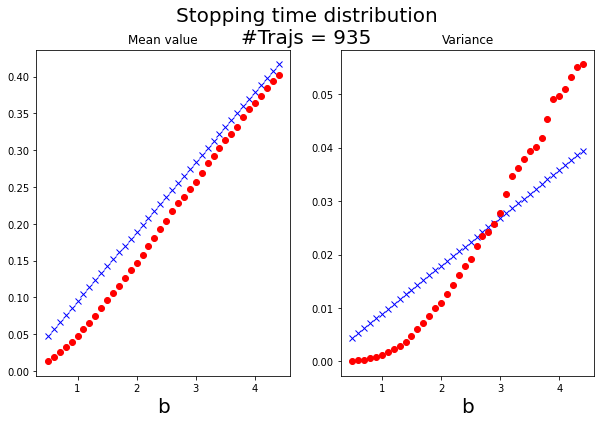

In [97]:
plt.figure(figsize=(10,6))
plt.suptitle("Stopping time distribution\n#Trajs = {}".format(len(stops)),size=20)
ax=plt.subplot(121)
ax.set_title("Mean value")
ax.plot(boundsB,boundsB/mu, 'x', color="blue", label="analytical")
ax.plot(boundsB,np.mean(stops,axis=0), 'o',color="red", label="numerics")
ax.set_xlabel("b", size=20)
ax=plt.subplot(122)
ax.set_title("Variance")
ax.plot(boundsB,boundsB/(mu**2), 'x', color="blue", label="analytical")
ax.plot(boundsB,np.std(stops,axis=0)**2, 'o',color="red", label="numerics")
ax.set_xlabel("b", size=20)
#plt.savefig(path+"stopping_times_moments.pdf")

Deterministic strategies

In [105]:
alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)



In [121]:
boundsB[-1]

4.399999999999999

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero e

Text(0, 0.5, 't')

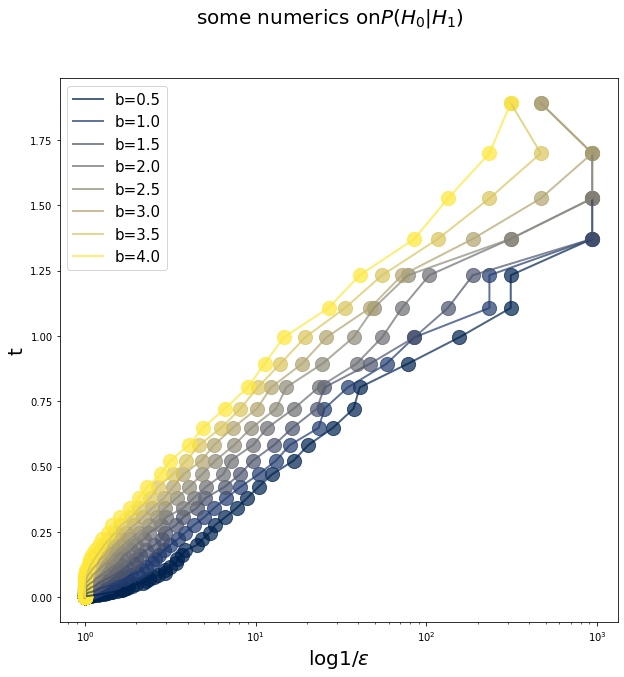

In [228]:
maps = plt.get_cmap("cividis")

plt.figure(figsize=(10,10))
plt.suptitle("some numerics on" + r'$P(H_0|H_1)$', size=20)
ax=plt.subplot(111)
indboundsplot = list(range(0,len(boundsB)))[0:38:5]
boundsplot = [boundsB[int(k)] for k in indboundsplot]
colors = maps(np.linspace(0,1,len(boundsplot)))
c=-1
for k, b in zip(indboundsplot, boundsplot):
    c+=1
    ax.scatter(1/alphas[k,:],timind,  color=colors[c], s=200, alpha=0.7)
    ax.plot(1/alphas[k,:],timind,  color=colors[c], linewidth=2, alpha=0.7, label="b={}".format(np.round(b,2)))
    
ax.legend(prop={"size":15})
ax.set_xscale("log")
ax.set_xlabel(r'$\log 1/\epsilon$',size=20)
ax.set_ylabel("t",size=20)

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, '$\\log 1/ P(h0|h1)$')

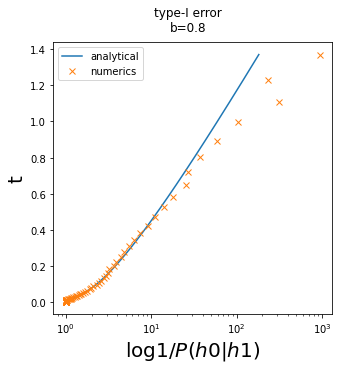

In [229]:
fig = plt.figure(figsize=(5,5))
b = boundsB[3]

plt.suptitle("type-I error\nb={}".format(np.round(b,3)))
ax=plt.subplot(111)
errs_num = alphas[np.argmin(np.abs(boundsB-b)),:]
lim = np.argmin(np.abs(np.array(timind) - 1.5))
alpha_analytic = np.array([0.5*(1- erf( (-b + mu*t)/np.sqrt(4*mu*t)) ) for t in timind])
ax.plot((1/alpha_analytic)[:lim], timind[:lim],label="analytical")
ax.plot((1/errs_num)[:lim], timind[:lim],'x', label="numerics")
ax.legend()
ax.set_xscale("log")
ax.set_ylabel("t", size=20)
ax.set_xlabel(r'$\log 1/ P(h0|h1)$', size=20)

In [201]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in boundsB]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb,:] - errs[indb]))] for indb in range(len(boundsB))]

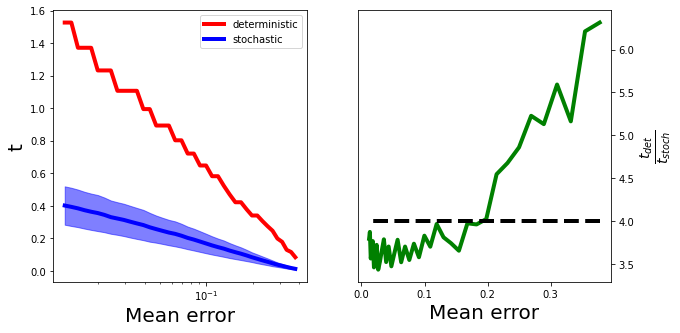

In [230]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)
stoch =  np.mean(stops1, axis=0)
stoch_std = np.std(stops1, axis=0)
ax.plot(errs, times_alpha_to_errB, color="red", linewidth=4,label="deterministic")
ax.plot(errs, stoch, color="blue", linewidth=4, label="stochastic")
ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
ax.set_xscale("log")
ax.set_xlabel("Mean error", size=20)
ax.set_ylabel("t", size=20)
ax.legend()

ax = plt.subplot(122)
ax.plot(errs, times_alpha_to_errB/stoch, linewidth=4, color="green")
ax.plot(errs, np.ones(len(stoch))*4,  '--', linewidth=4,color="black")
ax.set_xlabel("Mean error", size=20)
ax.set_ylabel(r'$\frac{t_{det}}{t_{stoch}}$', size=20)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

In [ ]:
timind